In [4]:
import time
from matplotlib.colors import ListedColormap


import tyssue
from tyssue import History
from tyssue.io.hdf5 import save_datasets, load_datasets
from tyssue.dynamics import effectors, model_factory, model_factory_vessel, model_factory_cylinder
from tyssue.generation.hexagonal_grids import hexa_cylinder
from tyssue.generation.shapes import sheet_from_cell_centers
from tyssue.geometry.cylinder_geometry import CylinderGeometry, CylinderGeometryInit
from tyssue import config
from tyssue.draw import sheet_view, create_gif
from tyssue.geometry.vessel_geometry import VesselGeometry as geom
from tyssue.solvers.viscous import EulerSolver
from tyssue.draw.ipv_draw import browse_history
from tyssue.topology.sheet_topology import cell_division, drop_face, split_vert
from tyssue.topology.base_topology import remove_face
from tyssue.behaviors import EventManager
from tyssue.generation.modifiers import create_anchors
# try:
#     from ..behaviors.behaviors import *
# except:
#     print("Failed relative import, attempting direct import")
#     from vivarium_tyssue.behaviors import *
# import ipyvolume as ipv

from process_bigraph import Process, Composite
from process_bigraph.emitter import emitter_from_wires, gather_emitter_results

%load_ext snakeviz

In [2]:
# def fix_points_cylinder(sheet, radius):
#     xy = sheet.vert_df[['x', 'y']].to_numpy()
#     r = np.linalg.norm(xy, axis=1)
#     r_safe = np.where(r == 0, 1e-12, r)
#     xy_on_cylinder = (radius/r_safe)[:, None] * xy
#     sheet.vert_df['x'] = xy_on_cylinder[:, 0]
#     sheet.vert_df['y'] = xy_on_cylinder[:, 1]

In [3]:
# def divide_cylinder(sheet, manager, geom, division_rate, dt, radius):
#     update_stem_cells(sheet)
#     stem_cells = sheet.face_df.loc[(sheet.face_df["stem_cell"] == 1) & (sheet.face_df["area"]>=0.7*sheet.face_df["area"].mean())].copy()
#     n_stem = len(stem_cells)
#     cell_ids = list(stem_cells["unique_id"])
#     n_divisions = np.random.binomial(n=n_stem, p=division_rate * dt)
#     dividing_cells = np.random.choice(cell_ids, size=n_divisions, replace=False)
#
#     for cell_id in dividing_cells:
#         cell_idx = int(sheet.face_df[sheet.face_df["unique_id"] == cell_id].index[0])
#         daughter = cell_division(sheet, cell_idx, geom)
#     manager.append(divide_cylinder, geom=geom, division_rate=division_rate, dt=dt, radius=radius)
#     fix_points_cylinder(sheet, radius=radius)

In [4]:
# def apoptosis_cylinder(sheet, manager, death_rate, dt, radius, geom):
#     update_stem_cells(sheet)
#     dying_cells = sheet.face_df.loc[sheet.face_df["dying_cell"] == 1]
#     n_dying = len(dying_cells)
#     cell_ids = list(dying_cells["unique_id"])
#     n_deaths = np.random.binomial(n=n_dying, p=death_rate * dt)
#     to_kill = np.random.choice(cell_ids, size=n_deaths, replace=False)
#
#     for cell_id in to_kill:
#         cell_idx = int(sheet.face_df[sheet.face_df["unique_id"] == cell_id].index[0])
#         # if sheet.face_df.loc[cell_idx, "boundary"] == 0:
#         vertex = remove_face(sheet, cell_idx)
#         # else:
#         #     vertex = drop_face(sheet, cell_idx, geom)
#         # split_vert(sheet, vertex)
#     manager.append(apoptosis_cylinder, death_rate=death_rate, dt=dt, radius=radius, geom=geom)
#     fix_points_cylinder(sheet, radius=radius)

In [3]:
def auto_correlated_tension(sheet, manager, sigma, phi):
    """
    Parameters:
    sheet: tyssue.Sheet object
    manager: EventManager object
    sigma: float, standard deviation
    phi: float, autocorrelation factor between 0 and 1 (AR(1) autocorrelation factor)
        closer to 1 means stronger correlation
    Returns:
    updates sheet.edge_df["line_tension"]
    """
    noise = np.random.normal(loc=0, scale=sigma, size=len(sheet.edge_df["line_tension"]))
    sheet.edge_df["line_tension"] =  phi * sheet.edge_df["line_tension"] + noise
    manager.append(auto_correlated_tension, sigma=sigma, phi=phi)

In [6]:
# def update_stem_cells(eptm):
#     eptm.face_df['stem_cell'] = 0
#     eptm.face_df['dying_cell'] = 0
#     eptm.face_df.loc[(eptm.face_df["boundary"] != 1) & (eptm.face_df["z"] < 0), "stem_cell"] = 1
#     eptm.face_df.loc[(eptm.face_df["z"] > 0), "dying_cell"] = 1

In [5]:
radius = 2.576
#generate cylindrical tissue
points_xyz = hexa_cylinder(16,30, radius = radius, noise = 0.0, capped = True)
sheet = sheet_from_cell_centers(points_xyz)
sheet = sheet.extract_bounding_box(z_boundary = (-10.1, 30), coords=['x', 'y', 'z'])
sheet.sanitize(trim_borders=False)
create_anchors(sheet)
sheet = sheet.extract_bounding_box(z_boundary = (-10.1, 10), coords=['x', 'y', 'z'])
sheet.sanitize(trim_borders=False)
geom.update_all(sheet)
sheet.network_changed = False

/opt/anaconda3/envs/vivarium-tyssue/lib/python3.12/site-packages/tyssue/core/objects.py:291: FutureWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  self.cell_df["num_faces"] = self.edge_df.groupby("cell").apply(
/opt/anaconda3/envs/vivarium-tyssue/lib/python3.12/site-packages/tyssue/core/objects.py:935: FutureWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  face_v = self.edge_df.groupby("face").apply(lambda df: frozenset(df["srce"]))


In [8]:
# save_datasets("test_cylinder.hf5", sheet)

In [6]:
sheet.face_df.loc[(sheet.face_df["z"]<8) & (sheet.face_df["z"]>-8), "area"].mean()

1.0001577509936472

In [10]:
from bigraph_schema.schema import dtype_schema
def get_frame_schema(df):
    schema = {}
    for column in df.columns:
        schema[column] = dtype_schema(df.loc[:, column].dtype)
    return schema

In [11]:
schema = get_frame_schema(sheet.face_df)

In [12]:
schema

{'x': Float(_default=None),
 'y': Float(_default=None),
 'z': Float(_default=None),
 'num_sides': Integer(_default=None),
 'area': Float(_default=None),
 'perimeter': Float(_default=None),
 'is_alive': Integer(_default=None),
 'id': Integer(_default=None),
 'unique_id': Integer(_default=None),
 'unique_id_max': Integer(_default=None),
 'face_o': Integer(_default=None),
 'opposite': Integer(_default=None),
 'vol': Float(_default=None),
 'phi': Float(_default=None),
 'rho': Float(_default=None),
 'theta': Float(_default=None),
 'at_border': Integer(_default=None),
 'boundary': Integer(_default=None)}

In [16]:
def get_dataset_schema(eptm):
    schema = {}
    for df_name in ["vert_df", "edge_df", "face_df", "cell_df"]:
        if getattr(eptm, df_name) is not None:
            schema[df_name] = {"_columns" : get_frame_schema(getattr(eptm, df_name))}
    schema.update({"_type" : "tyssue_data"})
    return schema

In [18]:
from pprint import pprint
schema = get_dataset_schema(sheet)
pprint(schema)

{'_type': 'tyssue_data',
 'edge_df': {'_columns': {'at_border': Integer(_default=None),
                          'boundary': Integer(_default=None),
                          'cell': None,
                          'cell_o': None,
                          'cx': Float(_default=None),
                          'cy': Float(_default=None),
                          'cz': Float(_default=None),
                          'dx': Float(_default=None),
                          'dy': Float(_default=None),
                          'dz': Float(_default=None),
                          'edge_o': None,
                          'face': Integer(_default=None),
                          'face_o': None,
                          'fx': Float(_default=None),
                          'fy': Float(_default=None),
                          'fz': Float(_default=None),
                          'is_active': None,
                          'is_anchor': Integer(_default=None),
                          'is_va

In [15]:
hasattr(sheet, "cell_df")

True

In [10]:
colors = ["green", "coral", "pink", "yellow", "purple"]
cmap = ListedColormap(colors)
sheet.face_df["color"] = 0
sheet.face_df.loc[(sheet.face_df["z"]<-5), "color"] = 1
sheet.face_df.loc[(sheet.face_df["z"]>-5) & (sheet.face_df["z"]<0), "color"] = 2
goblet_fraction = 0.2
enterocyte_fraction = 0.15
gob_to_replace = int(len(sheet.face_df) * goblet_fraction)
gob_indices = np.random.choice(sheet.face_df.loc[(sheet.face_df["z"]>0)].index, size=gob_to_replace)
sheet.face_df.loc[gob_indices, "color"] = 3

ent_to_replace = int(len(sheet.face_df) * enterocyte_fraction)
ent_indices = np.random.choice(sheet.face_df.loc[(sheet.face_df["z"]>0) & (sheet.face_df["color"] != 3)].index, size=ent_to_replace)
sheet.face_df.loc[ent_indices, "color"] = 4

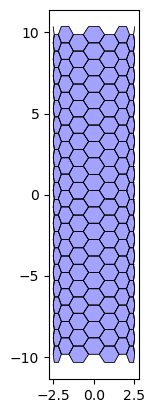

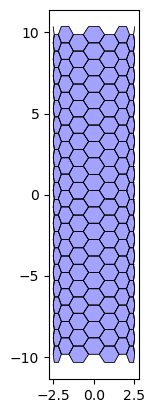

In [15]:
draw_specs = tyssue.config.draw.sheet_spec()
draw_specs["face"]["visible"] = True
draw_specs["face"]["visible"] = True
draw_specs["face"]["alpha"] = 0.2
draw_specs["face"]["color"] = "blue"
draw_specs["edge"]["color"] = "black"

fig, ax = sheet_view(sheet, coords=['x', 'z'], mode="2D", dpi=300, **draw_specs)
fig

In [12]:
#generate model
model = model_factory_vessel([
    effectors.LineTension,
    effectors.FaceAreaElasticity,
    effectors.PerimeterElasticity,
], effectors.FaceAreaElasticity)

In [13]:
#set model parameters
sheet.face_df["area_elasticity"] = 1
sheet.face_df["prefered_area"] = 1
sheet.face_df["perimeter_elasticity"] = 1
sheet.face_df["prefered_perimeter"] = 3.5
sheet.edge_df["line_tension"] = np.random.normal(loc=0, scale=0.01, size=len(sheet.edge_df))
sheet.edge_df["is_active"] = 1
sheet.vert_df["viscosity"] = 5
sheet.vert_df["prefered_deviation"] = 0
sheet.vert_df["surface_elasticity"] = 5
sheet.settings["threshold_length"] = 0.1
geom.update_all(sheet)

In [14]:
sheet.edge_df["face"]

edge
0       123
1       123
2       123
3       123
4       123
       ... 
1915    284
1916    284
1917    284
1918    284
1919     68
Name: face, Length: 1920, dtype: int64

In [15]:
history = History(sheet)

In [16]:
#set time-step
dt=0.1

In [17]:
#initialize manager and add division and apoptosis
#set division and apoptosis parameters
manager = EventManager()
manager.append(divide_cylinder, geom=geom, division_rate=0.0005, dt=dt, radius=radius)
manager.append(apoptosis_cylinder, death_rate=0.0005, dt=dt, radius=radius, geom=geom)
manager.append(auto_correlated_tension, sigma = 0.01, phi=0.5)

In [18]:
#initialize solver
solver = EulerSolver(
    sheet,
    geom,
    model,
    history=history,
    auto_reconnect=True,
    manager=manager,
)

In [19]:
sheet.edge_df["is_active"]

edge
0       1
1       1
2       1
3       1
4       1
       ..
1915    1
1916    1
1917    1
1918    1
1919    1
Name: is_active, Length: 1920, dtype: int64

In [20]:
#set time variables
dt = dt
tf = 300
sheet.settings["dt"] = dt
sheet.settings["p_4"] = 1/(dt)
sheet.settings["p_5p"] = 1/(dt)
#run simulation
start = time.time()
res = solver.solve(tf=tf, dt = dt)
print(f"Time Elapsed: {time.time()-start}")

Time Elapsed: 84.18165802955627


In [21]:
sheet.edge_df

,at_border,boundary,cell,cell_o,cx,cy,cz,dx,dy,dz,...,trgt,trgt_o,tx,ty,tz,unique_id,unique_id_max,ux,uy,uz
edge,,,,,,,,,,,,,,,,,,,,,
0,0,0,0,0,0.0,0.0,0.0,-0.215825,-0.147281,0.420867,...,214,410,-1.558054,2.051400,5.091186,0,6120,-0.435711,-0.297332,0.849653
1,0,0,0,0,0.0,0.0,0.0,-0.735950,-0.304957,-0.002332,...,171,339,-1.342229,2.198681,4.670318,2,6120,-0.924107,-0.382924,-0.002929
2,0,0,0,0,0.0,0.0,0.0,-0.307078,-0.054927,-0.535432,...,168,336,-0.606279,2.503638,4.672651,4,6120,-0.495578,-0.088645,-0.864110
3,0,0,0,0,0.0,0.0,0.0,0.226362,0.036748,-0.371823,...,170,338,-0.299202,2.558565,5.208083,6,6120,0.518196,0.084126,-0.851190
4,0,0,0,0,0.0,0.0,0.0,0.824828,0.328139,0.025125,...,169,337,-0.525564,2.521817,5.579906,8,6120,0.928981,0.369574,0.028297
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1894,0,0,0,0,0.0,0.0,0.0,0.021628,-0.011439,-0.114146,...,659,663,1.215141,2.271389,7.304019,1807,6120,0.185267,-0.097985,-0.977798
1895,0,0,0,0,0.0,0.0,0.0,0.127065,0.009896,-0.062702,...,660,164,-0.136415,2.572385,7.878285,1415,6120,0.894737,0.069680,-0.441518
1896,0,0,0,0,0.0,0.0,0.0,-0.127065,-0.009896,0.062702,...,369,861,-0.263480,2.562490,7.940987,1510,6120,-0.894737,-0.069680,0.441518


In [20]:
ipv.clear()

In [30]:
ipv.clear()
browse_history(history,**draw_specs)

Container(figure=Figure(box_center=[0.5, 0.5, 0.5], box_size=[1.0, 1.0, 1.0], camera=PerspectiveCamera(fov=45.…

interactive(children=(IntSlider(value=0, description='i', max=20000), Output()), _dom_classes=('widget-interac…

In [22]:
len(sheet.face_df)

289

In [23]:
sheet.edge_df["is_active"]

edge
0       1
1       1
2       1
3       1
4       1
       ..
1705    1
1706    1
1707    1
1708    1
1709    1
Name: is_active, Length: 1710, dtype: int64

In [31]:
ipv.clear()
fig, mesh = sheet_view(sheet, coords=['x', 'y', 'z'], mode="3D", **draw_specs)
ipv.pylab.xyzlabel("x-axis", "y-axis", "z-axis")
ipv.pylab.style.axes_on()
fig

Figure(box_center=[0.5, 0.5, 0.5], box_size=[1.0, 1.0, 1.0], camera=PerspectiveCamera(fov=45.0, position=(0.0,…

In [25]:
sheet1 = history.retrieve(0.0)

In [23]:
if not sheet.cell_df:
    print("True")
else:
    print("False")

True


In [24]:
sheet.face_df

,x,y,z,num_sides,area,perimeter,is_alive,id,unique_id,unique_id_max,face_o,opposite,vol,phi,rho,theta,at_border,boundary
face,,,,,,,,,,,,,,,,,,
0,-2.490072,4.727755e-06,0.757565,6,1.000212,3.739236,1,0,0,1024,3,-1,0.0,-3.141593,0.500916,0.050717,0,0
1,-2.301152,9.531816e-01,0.252518,6,1.001060,3.740757,1,0,1,1024,4,-1,0.0,2.748894,0.500499,0.016918,0,0
2,-2.299782,9.526065e-01,1.262305,6,0.999166,3.737362,1,0,2,1024,5,-1,0.0,2.748894,0.501880,0.084400,0,0
3,-2.488344,-1.564364e-07,1.766692,6,0.998135,3.735496,1,0,3,1024,6,-1,0.0,-3.141593,0.503386,0.117894,0,0
4,-1.757795,1.757766e+00,4.791965,6,0.999161,3.736903,1,0,4,1024,10,-1,0.0,2.356194,0.524545,0.311092,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
315,0.000006,2.487605e+00,-9.341089,6,1.001904,3.741786,1,0,411,1024,505,-1,0.0,1.570796,0.589656,-0.559565,1,1
316,0.951932,2.298131e+00,-8.835363,6,1.000425,3.739263,1,0,412,1024,506,-1,0.0,1.178097,0.580820,-0.534861,0,0
317,1.758973,1.758955e+00,-8.330350,6,0.999316,3.737391,1,0,413,1024,507,-1,0.0,0.785398,0.572398,-0.509413,0,0


In [32]:
ipv.clear()
browse_history(history, **draw_specs)

Container(figure=Figure(box_center=[0.5, 0.5, 0.5], box_size=[1.0, 1.0, 1.0], camera=PerspectiveCamera(fov=45.…

interactive(children=(IntSlider(value=0, description='i', max=20000), Output()), _dom_classes=('widget-interac…

In [ ]:
def get_frame_schema(df):
    schema = {}
    for column in df.columns:
        schema[column] = df.loc[:, column].dtype
    return schema

#### Generate A Flat Rectangular Tissue

In [17]:
from tyssue.generation.hexagonal_grids import hexa_grid2d, hexa_grid3d
from tyssue.geometry.sheet_geometry import SheetGeometry as geom
from tyssue import Sheet

In [34]:
sheet = Sheet.planar_sheet_3d(
    'basic2D', # a name or identifier for this sheet
    nx=17, # approximate number of cells on the x axis
    ny=15, # approximate number of cells along the y axis
    distx=1.076, # distance between 2 cells along x
    disty=1.076 # distance between 2 cells along y
)
sheet.sanitize(trim_borders=True)
geom.update_all(sheet)

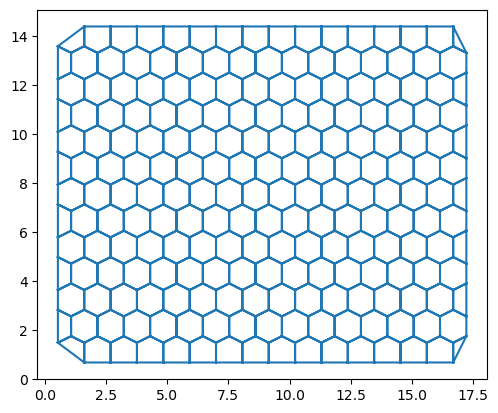

In [35]:
fig, ax = sheet_view(sheet, coords=['x', 'y'], mode="quick")

In [36]:
sheet.face_df["area"].mean()

np.float64(1.0930685673076925)

In [37]:
save_datasets("test_square.hf5", sheet)

In [1]:
sheet

NameError: name 'sheet' is not defined

In [8]:
sheet.vert_df

,x,y,z,is_active,rho,height,basal_shift,unique_id,unique_id_max,srce_o,boundary,at_border,is_anchor,tx,ty,tz,distance_origin,ox,oy
vert,,,,,,,,,,,,,,,,,,,
0,-1.262771,2.191019,4.791601,1,0.395913,0.0,4.0,0,1020,0,0,0,0,0.866404,0.499343,-0.0,2.528864,-0.499343,0.866404
1,1.262850,2.191143,4.791882,1,0.395913,0.0,4.0,1,1020,1,0,0,0,0.866403,-0.499345,0.0,2.529011,0.499345,0.866403
2,0.657037,2.444687,-6.311706,1,0.395461,0.0,4.0,16,1020,18,0,0,0,0.965730,-0.259551,0.0,2.531441,0.259551,0.965730
3,1.264087,2.193277,-6.311800,1,0.395461,0.0,4.0,17,1020,19,0,0,0,0.866402,-0.499347,0.0,2.531478,0.499347,0.866402
4,0.657825,2.447715,-0.252741,1,0.396640,0.0,4.0,18,1020,20,0,0,0,0.965732,-0.259541,0.0,2.534570,0.259541,0.965732
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
667,2.007078,1.542492,-6.816587,1,0.395298,0.0,4.0,841,1020,999,0,0,0,0.609360,-0.792894,0.0,2.531333,0.792894,0.609360
668,1.263847,2.192867,-7.320830,1,0.395132,0.0,4.0,842,1020,1000,0,0,0,0.866403,-0.499346,0.0,2.531003,0.499346,0.866403
669,1.542182,2.006640,-7.825374,1,0.394964,0.0,4.0,843,1020,1001,0,0,0,0.792889,-0.609366,0.0,2.530796,0.609366,0.792889
